# Est-ce que c'est normal ?

Comment étudier la distribution statistique de données expérimentales. 

In [3]:
# <!-- collapse=True -->
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=18)

#params = {'legend.fontsize': 'x-large',
#          'figure.figsize': (15, 5),
#         'axes.labelsize': 'x-large',
#         'axes.titlesize':'x-large',
#         'xtick.labelsize':'x-large',
#         'ytick.labelsize':'x-large'}
#pylab.rcParams.update(params)

## Introduction

On va regarder ici les moyens pratiques d'étudier la distribution statistique d'un ensemble de mesures expérimentalles, et de tester son adéquation avec une loi théorique donnée, typiquement avec la loi Normale (Gaussienne).

Voici trois jeux de données différents, ayant chacun 100 points. Ces données peuvent par exemple être la largeur, la hauteur et le poids d'un échantillons de 100 pièces issus de la même ligne de production. Les variations observées peuvent alors venir du procédé de fabrication ou alors de la méthode de mesure. 

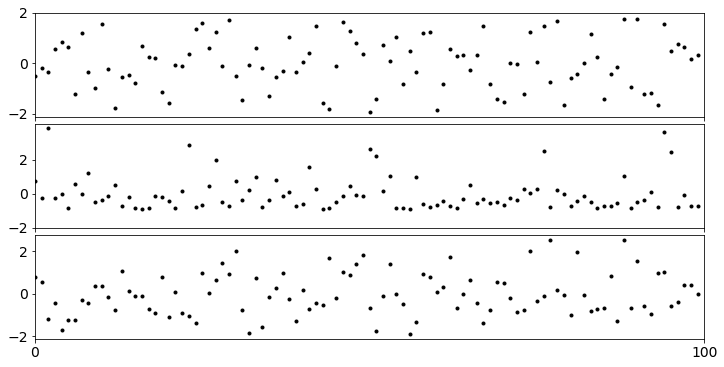

In [4]:
# <!-- collapse=True -->

import random

N = 100
X_exemples = {}
X_exemples['normal'] = np.random.normal(loc=0.0, scale=1.0, size=N) 
X_exemples['uniforme'] = np.random.random(N)
X_exemples['exponential'] = np.random.exponential(scale=1.0, size=N)
#X = np.random.logistic(loc=0.0, scale=1.0, size=2000)

n_graph = len( X_exemples )


# Normé et centré
for k, X in X_exemples.items():
    X_exemples[k] = (X-np.mean(X))/np.std(X)
   

fig, ax = plt.subplots(n_graph, sharex=True, figsize=(12, 2*n_graph));
for i, X in enumerate( X_exemples.values() ):
    ax[i].plot(  X,  '.k' );
    
    ax[i].set_xticks([0, N]);
    ax[i].set_yticks([-2, 0, 2]);


plt.subplots_adjust(wspace=0, hspace=.07);
ax[i].set_xticks([0, N]);
ax[i].set_xlim([0, N]);
# share x only
#ax2 = plt.subplot(312, sharex=ax1)
#plt.plot(t, s2)
# make these tick labels invisible
#plt.setp(ax2.get_xticklabels(), visible=False)

Il est habituel de caractériser de tels échantillons par **la moyenne** et **l'écart-type**, mais ce n'est pas ce qui nous interesse ici. Les valeurs ont été centrées et normées de façon à ce que les 3 ensembles aient la même moyenne (0) et le même écart-type (1). On distingue pourtant une différence entre ces trois jeux de données. On va voir si l'on peut caractériser plus finement cela.

Ce qui nous interesse ici est donc la **distribution statistique des valeurs** et comment l'étudier experimentalement.

## Qu'est qu'une distribution statistique ?

La distribution statistique est pour une variable aléatoire la probabilité d'obtenir cette valeur: $f(x) = P[{\small x=x_0} ]$

Par exemple pour le lancé d'un dé la distribution est uniforme: $P[{\small x=1}]=P[{\small x=2}]=...=P[{\small x=6}]=1/6$

Les distributions peuvent être, entre-autre : - discretes ou (à support) continues - symétriques ou non-symétriques

Il existe un grand nombre de distributions statistiques, plus ou moins complexes: voir 
[Gallery of Distributions](http://www.itl.nist.gov/div898/handbook/eda/section3/eda366.htm), 
[wikipedia](https://en.wikipedia.org/wiki/Symmetric_probability_distribution) ou encore la [doc scipy](https://docs.scipy.org/doc/scipy-0.18.1/reference/stats.html#continuous-distributions).

La plus célèbre de toutes étant la distribution gaussienne, ou loi Normale: $\exp( - x^2 )$.

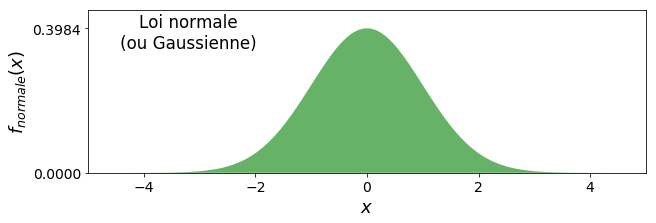

In [5]:
# <!-- collapse=True -->
from scipy.stats import norm
x = np.linspace(-5, 5, 100)
plt.figure(figsize=(10, 3) )
plt.fill_between(x, norm.pdf(x)  , alpha=0.6, facecolor='green');
plt.ylim([0, .45]); plt.xlim([-5, 5]);
plt.yticks([0, np.max(norm.pdf(x)) ]);
plt.xlabel('$x$'); plt.ylabel('$f_{normale}(x)$');
plt.title("Loi normale\n(ou Gaussienne)", x=0.18, y=0.73);

## Utilisation des histogramme ?

Nous souhaitons, à partir de données expérimentales, tracer la distribution statistique sous-jacente. Le moyen le plus connu, et intuitif, est de tracer un histogramme. Ce n'est en réalité pas le plus pratique et rigoureux (avec un ordinateur). 

Avec un histogramme on calcul la probabilité, non d'obtenir une valeur unique de $x$ (ce qui n'est pas possible), mais la probabilité d'obtenir la valeur dans un intervalle: $$P_i\left[  b_i < x_m < b_{i+1} \right]$$

Il est alors necessaire de spécifier la taille de cet intervalle. La forme de la distribution obtenue est alors fortement sensible au nombre de valeur tombant dans chaque intervalle. Le graphique suivant illustre cela, avec un jeu de données de 100 points suivant une distribution normale.

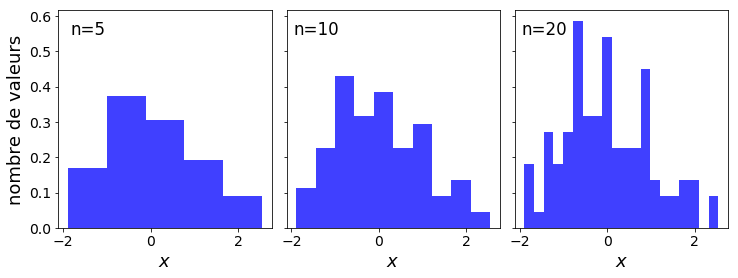

In [6]:
# <!-- collapse=True -->
nombre_intervals = [5, 10, 20]
n_graph = len(nombre_intervals)

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(n_graph*4, 4));
for i, n in enumerate( nombre_intervals ):
    nBin, bins, patches = ax[i].hist(X_exemples['normal'], n, normed=True, facecolor='blue', alpha=0.75)
    ax[i].set_xticks([-2, 0, 2]);
    ax[i].set_xlabel('$x$');
    ax[i].set_title("n=%i"%n, x=0.14, y=0.86)
    
plt.subplots_adjust(wspace=0.07, hspace=.0);
ax[0].set_ylabel('nombre de valeurs');

Pour qu'il ne soit pas necessaire de spécifier un intervalle d'observation, on utilise en pratique la fonction de répartition.

## Fonction de répartition

La fonction de répartition $F(x)$ est la probabilité d'obtenir une valeur inférieure à $x$: 
$$F(x) = P[\, x_m < x \,]$$

$F(x)$ correspond à l'intégrale de la densité de probabilité $f(x)$. Il est très simple d'obtenir cette fonction numériquement. L'astuce est de trier les valeurs de $X$ par ordre croissant. 

En effet, la probabilité empirique d'obtenir une mesure inférieure à $x_i$ est le nombre de valeur plus petite que celle-ci divisé par le nombre total de mesures ($N$). Une fois les valeurs triées, le nombre de valeur plus petites est simplement la position (l'indice) de cette valeur. On peut alors normer les indices par le nombre totale de valeurs ($N$).


$$ \begin{align}
P[ x< min(X) ] &= 0  \\
P[ x< max(X) ] &= 1 \\
P[ x< x_i ] &= i/N \; avec \; X_i = sort(X)[i]
\end{align} $$

[ref. wikipedia]( https://fr.wikipedia.org/wiki/Fonction_de_r%C3%A9partition_empirique )

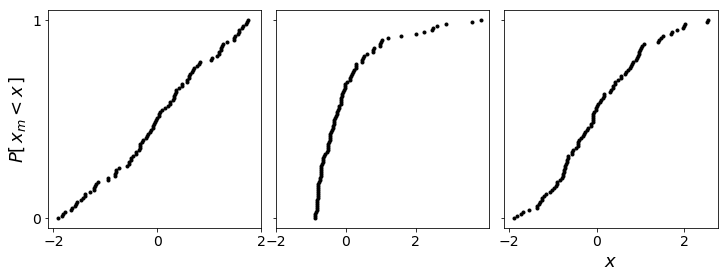

In [7]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(n_graph*4, 4));
for i, X in enumerate( X_exemples.values() ):
    Xordered = np.sort( X )
    fraction = np.linspace(0, 1, len(X) )
    ax[i].plot( Xordered, fraction ,  '.k' );
    ax[i].set_xticks([-2, 0, 2]);

plt.subplots_adjust(wspace=0.07, hspace=.0);
ax[i].set_yticks([0, 1]);
ax[0].set_ylabel('$P[\,x_m<x\,]$');plt.xlabel('$x$');

Ce sont les mêmes données, mais representées d'une façon différentes. Il n'y a pas eu de calcul (autre qu'une normalisation) ou bien d'informations ajoutées.
On constate qu'elles n'ont pas la même distribution.

Rq.: Pour obtenir la densité de probalité $f(x)$, il conviendrait de differencier ces courbes. Du fait du bruit ce n'est pas une bonne idée.

## Diagrame Quantile-Quantile

Pour aller plus loin, il existe des moyen de comparer plus finement les distributions entre elles, ou avec des distributions théoriques. Par exemple, la première courbe est t'elle réellement différente de la troisième ?

Voir entre autre sur Wikipedia: [Droite de Henry](https://fr.wikipedia.org/wiki/Droite_de_Henry) ou [Diagramme Quantile-Quantile](https://fr.wikipedia.org/wiki/Diagramme_Quantile-Quantile).

La fonction Scipy `probplot` permet de réaliser un diagrame Quantile-Quantile par rapport à une distribution de réference, et en même temps qu'une regression linéaire sur les points obtenus ([doc](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.stats.probplot.html#scipy.stats.probplot)).

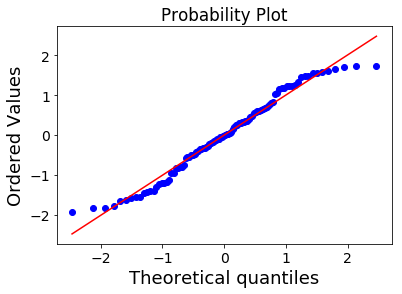

In [8]:
import scipy.stats as stats
 
X = X_exemples['uniforme']    
stats.probplot(X, dist="norm", plot=plt)
plt.show()

## Tests statistiques

Mais est-ce que l'écart observé est-il significatif ? à quoi comparer la différence observée ?
Dans l'exemple ci-dessus on voit que le $R^2$ de la regression n'est pas forcement un bon indicateur de la justesse du fit.

Il existe plusieurs test statistique permettant de decider si, oui ou non, la distribution correspond à la distribution théorique spécifiée. 

* Le **test du Chi-2** est peut-etre le plus connu. Il est basée sur l'histogramme, et donc finalement moins pertinent.

* Le test de **Kolmogorov-Smirnov** (K-S) : il semble basé sur le seul ecart maximal entre les deux fonctions de répartitions. Une différence sur les queux des distributions n'est donc pas forcément détectée. [Wikipedia](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)

* Le test de **Anderson-Darling** :  http://www.itl.nist.gov/div898/handbook/eda/section3/eda35e.htm et [wikipedia](https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test).

* The **Shapiro-Wilk** Test For Normality : http://www.itl.nist.gov/div898/handbook/prc/section2/prc213.htm

* **Cramér–von Mises criterion** : une version plus simple que _Anderson-darling_ ? intuitivement basée sur l'intégrale du carré de l'écart entre les deux distributions... ? [wikipedia](https://en.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93von_Mises_criterion#cite_note-anderson-3)

**réferences:**

- voir http://www.biostat.envt.fr/spip/IMG/pdf/cours1.pdf, page 77

- http://www.itl.nist.gov/div898/handbook/eda/section3/eda35e.htm

- Do the observations come from a particular distribution?
http://www.itl.nist.gov/div898/handbook/prc/section2/prc213.htm

Le test de Anderson-Darling est implémenté dans Scipy.stats pour les distributions Normale, exponentielle, logistique, et de Gumbel. ([doc]( https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html#scipy.stats.anderson))

_remarque:_ Les valeurs critiques sont fonction du nombre de points.

``` If A2 is larger than these critical values then for the corresponding significance level, the null hypothesis that the data come from the chosen distribution can be rejected.  {‘norm’,’expon’,’logistic’,’gumbel’,’gumbel_l’, gumbel_r’, ‘extreme1’} ```

In [9]:
from scipy.stats import anderson

In [10]:
anderson(X_exemples['uniforme'] , dist='norm')

AndersonResult(statistic=0.57113873819162109, critical_values=array([ 0.555,  0.632,  0.759,  0.885,  1.053]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

In [11]:
def testAnderson( X ):
    A2, Vc, Alphas = anderson( X  , dist='norm')

    k = 2
    if A2 > Vc[k]:
        print( "La distribution n'est PAS normale avec un risque de %f pourcent" % Alphas[k])
    else: 
        print( "La distribution EST normale avec un risque de %f pourcent" % Alphas[k])
        
#to do: chercher le risque minimal possible

In [12]:
for key, X in X_exemples.items():
    print( '%s: '%key )
    testAnderson( X )

uniforme: 
La distribution EST normale avec un risque de 5.000000 pourcent
exponential: 
La distribution n'est PAS normale avec un risque de 5.000000 pourcent
normal: 
La distribution EST normale avec un risque de 5.000000 pourcent


In [13]:
Xn = np.random.normal(loc=0.0, scale=1.0, size=200) 
anderson( Xn    , dist='norm')

AndersonResult(statistic=0.3521176591327162, critical_values=array([ 0.565,  0.644,  0.772,  0.901,  1.071]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

### Test du test sur un mélange de distribution

On peut étudier le comportement du test en l'évaluant sur un jeu de donnée construit comme mélange d'une distribution normale et d'une distribution uniforme. Le graphique suivant montre 5000 résultats de calculs du test d'Anderson sur des données de 400 points. La ligne horizontale rouge est la valeur critique pour un risque de 5%. 

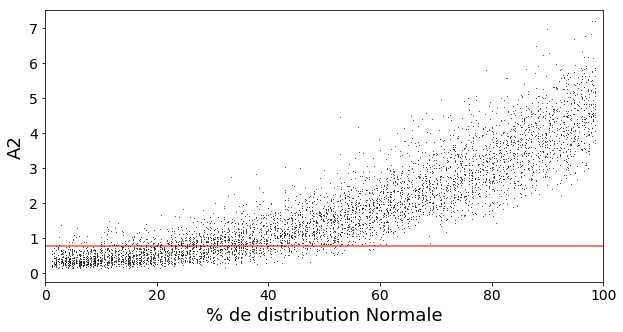

In [14]:
# <!-- collapse=True -->
n_points_graph = 5000
nMin, N = 5, 400

all_n1 = np.random.randint(nMin, high=N-nMin, size=n_points_graph)

A2norm_all = []
for n1 in all_n1:
    n2 = N - n1

    X2 = np.random.normal(loc=0.0, scale=1.0, size=n2) 
    #X1 = np.random.laplace(loc=0.0, scale=1.0, size=n1)
    X1 =  np.random.uniform(low=-.5, high=.5, size=n1)
    X1 = X1 / np.std( X1 )

    X = np.concatenate( [X1 , X2] )
    A2_norm, Vcrit, Alphas = anderson( X  , dist='norm')
    A2norm_all.append( A2_norm )
        
 
plt.figure(figsize=(10, 5) )
plt.hlines(Vcrit[2], 0, 99.9, colors='r', linestyles='solid', alpha=.7 )

pourcentage = all_n1/float( N )
plt.plot( 100*pourcentage, A2norm_all, ',k', alpha=.7  );
plt.xlim([0, 100]);

plt.xlabel(u'% de distribution Normale'); plt.ylabel(u'A2');

## Et avec des données réels ?

Par curiosité on peut regarder la distribution statistique de données réelles. On trouve l'historique du taux de change Dollar-Euro à l'adresse suivante : https://fred.stlouisfed.org/series/DEXUSEU

C'est une serie temporelle et les valeurs ont une certaine cohérence temporelle. On peut, en revanche, supposer que les variations à hautes fréquences correspondent à un bruit aléatoire. On regarde donc la premier dérivée du taux de change.

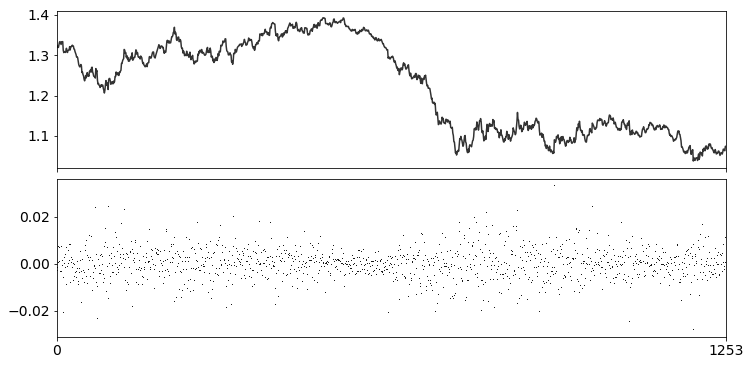

In [17]:
# <!-- collapse=True -->
data = np.load('./timeseriesdata.npy', encoding='bytes').item()
X, Y = data['DEXUSEU.csv']

dY = np.diff( Y, 1)

n_graph = 2
fig, ax = plt.subplots(n_graph, sharex=True, figsize=(12, 3*n_graph));

ax[0].plot(  Y ,  '-k', alpha=0.8  );
#ax[0].set_yticks([0, 160]);

ax[1].plot(  np.diff(Y) ,  ',k', alpha=0.9  );
#ax[1].set_yticks([-10, 0, 10]);
ax[1].set_xlim([0, len(Y)]);

plt.subplots_adjust(wspace=0, hspace=.07);
ax[-1].set_xticks([0, len(Y)]);

Regardons la répartition des valeurs:

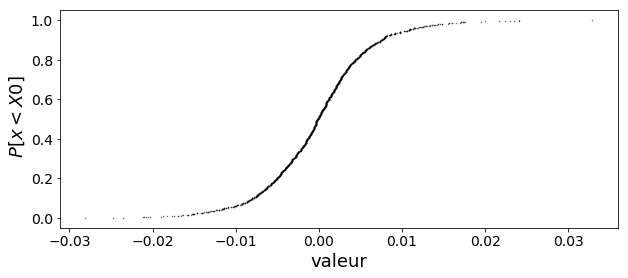

In [18]:
dYordered = np.sort( dY )
fraction = np.linspace( 0, 1, len(dY) )

plt.figure(figsize=(10, 4) )
plt.plot(  dYordered, fraction,  'k.', alpha=0.6, markersize=1);

plt.xlabel( 'valeur' ); plt.ylabel( ' $P[ x < X0 ]$' ); #$P( x < x^+ )$' ); 

Est-ce bien une distribution normale ?

In [19]:
testAnderson( dY )

La distribution n'est PAS normale avec un risque de 5.000000 pourcent


Ah ah! ... on peut comparer la distribution empirique avec celles théroriques:

In [23]:
from scipy.special import erf, erfinv

def Laplace(x):
    return .5 + .5*np.sign(x)*( 1 - np.exp( -np.abs(x)*np.sqrt(2) ) )

def Normale(x):
    r = .5*(1 + erf(x/np.sqrt(2) ))
    return r

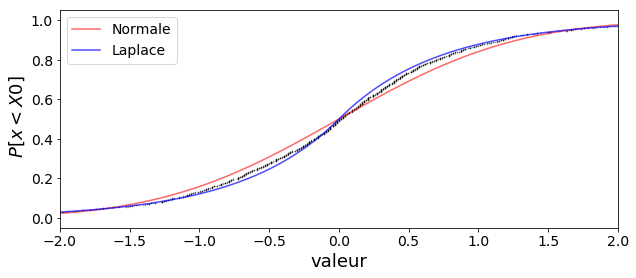

In [36]:
dYordered_norme = (dYordered -dYordered.mean() )/dYordered.std()

plt.figure(figsize=(10, 4) )
plt.plot(  dYordered_norme, fraction,  'k.', alpha=0.4, markersize=1);

plt.plot(  dYordered_norme, Normale(dYordered_norme),  'r-', alpha=0.6, label='Normale');
plt.plot(  dYordered_norme, Laplace(dYordered_norme),  'b-', alpha=0.7, label='Laplace');

plt.xlabel( 'valeur' ); plt.ylabel( ' $P[ x < X0 ]$' ); #$P( x < x^+ )$' );
plt.xlim([-2, 2]); plt.legend();